# mmFace + InsightFace2D Hybrid Model

## Build and Load Dataset

Real Dataset:
- 21 Subjects, 15 Experiments
  * Total 250 ARD frames -> Shuffle -> Take first 15 frames and split
  * Total 10 RGB embeddings -> Filter undetected -> Shuffle and Fill 15 frames and split

`15*15*21 = 4725 Data Points`

Fake Dataset:
- 21 Subjects, 3 Experiments
  * Total 74 ARD frames -> Shuffle -> Split
  * Total 10 RGB embeddings -> Filter undetected -> Shuffle and Fill 74 frames and split

`74*3*21 = 4662 Data Points`

`NB: If no RGB embedding for an subject experiment, need to completely remove that`

In [12]:
from hybrid_dataset import load_dataset, load_dataset_subject
from tqdm import tqdm
import numpy as np
import torch
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device, '\n')

RAW_PATH = os.path.relpath("../../Soli/soli_realsense/data")
num_subjects = 21

torch.cuda.empty_cache()
# train, validation, test = load_dataset(RAW_PATH, num_subjects)
train, validation, test = load_dataset_subject(RAW_PATH, num_subjects, batch_size=128, train_split=15/21, test_split=3/21, seed=seed)

cuda 



Train (Radar): torch.Size([4628, 3, 32, 16])
Train (RGB Embeddings): torch.Size([4628, 512])
Validation (Radar): torch.Size([788, 3, 32, 16])
Validation (RGB Embeddings): torch.Size([788, 512])
Test (Radar): torch.Size([788, 3, 32, 16])
Test (RGB Embeddings): torch.Size([788, 512])
Allocated: 0.16 GB


## Model Creation and Loading

In [3]:
from neural_nets import MMFaceHybrid
from utils import load_model, load_history
from torch import nn

num_epochs = 20
learning_rate = 0.01

lambda1, lambda2 = 1, 1

model = MMFaceHybrid(num_subjects).to(device)

# Loss + Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.001, momentum=0.9)

model_name = f"mmFace-hybrid-{lambda1},{lambda2}-ZERO_SHOT-{seed}-15.3.pt"
cur_epoch, loss_history, train_acc, val_acc = load_model(model_name, model, optimiser)

if len(loss_history) > 0:
    print(f"{model_name}\n\tEpoch: {cur_epoch}\n\tLoss: {loss_history[-1]:.4f}\n\tTrain Accuracy: {train_acc[-1]}\n\tValidation Accuracy: {val_acc[-1]}")

[Errno 2] No such file or directory: 'models/mmFace-hybrid-1,1-ZERO_SHOT-52-15.3.pt'


## Training

In [4]:
for epoch in range(cur_epoch, num_epochs):
    print(f"\nEpoch [{epoch}/{num_epochs-1}]:")
    if os.path.exists(f"models/{model_name}"):
        loss_history, train_acc, val_acc = load_history(f"models/{model_name}")

    model.train()
    # Running Loss and Accuracy
    running_loss, running_acc_s, running_acc_l, total_s, total_l = 0., 0., 0., 0., 0.

    for radar, rgb_emb, labels_s, labels_l in tqdm(train):
        # Forward Pass
        out1, out2 = model(radar, rgb_emb)
        _, preds_s = torch.max(out1.data, 1)
        _, preds_l = torch.max(out2.data, 1)
        loss1 = criterion(out1, labels_s)
        loss2 = criterion(out2, labels_l)
        loss = lambda1*loss1 + lambda2*loss2

        # Backward Pass and Optimise
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total_s += labels_s.size(0)
        total_l += labels_l.size(0)
        running_acc_s += (preds_s == labels_s).sum().item()
        running_acc_l += (preds_l == labels_l).sum().item()

        del radar, rgb_emb, labels_s, labels_l, out1, out2
        torch.cuda.empty_cache()
    
    avg_train_loss = running_loss/len(train)
    avg_train_acc_s = 100*running_acc_s/total_s
    avg_train_acc_l = 100*running_acc_l/total_l
    print(f"\tAverage Train Loss: {avg_train_loss:.4f}")
    print(f"\tTrain Accuracy (Subjects): {avg_train_acc_s:.4f}%")
    print(f"\tTrain Accuracy (Liveness): {avg_train_acc_l:.4f}%")

    torch.save({"epoch": epoch+1,
                "model_state_dict": model.state_dict(),
                "optimiser_state_dict": optimiser.state_dict(),
                "loss_history": loss_history + [avg_train_loss],
                "train_acc": train_acc + [(avg_train_acc_s, avg_train_acc_l)],
                "val_acc": val_acc},
                f"models/{model_name}")
    
    # Validation
    model.eval()
    with torch.no_grad():
        correct_s, correct_l, total_s, total_l = 0., 0., 0., 0.
        for radar, rgb_emb, labels_s, labels_l in validation:
            out1, out2 = model(radar, rgb_emb)
            _, preds_s = torch.max(out1.data, 1)
            _, preds_l = torch.max(out2.data, 1)
            total_s += labels_s.size(0)
            total_l += labels_l.size(0)
            correct_s += (preds_s == labels_s).sum().item()
            correct_l += (preds_l == labels_l).sum().item()
            del radar, rgb_emb, labels_s, labels_l, out1, out2
        
        avg_val_acc_s = 100*correct_s/total_s
        avg_val_acc_l = 100*correct_l/total_l
        print(f"\tValidation Accuracy (Subject): {avg_val_acc_s:.4f}%")
        print(f"\tValidation Accuracy (Liveness): {avg_val_acc_l:.4f}%")

    model_checkpoint = torch.load(f"models/{model_name}")
    model_checkpoint["val_acc"].append((avg_val_acc_s, avg_val_acc_l))
    torch.save(model_checkpoint, f"models/{model_name}")


Epoch [0/19]:


  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:01<00:00, 26.99it/s]


	Average Train Loss: 1.4869
	Train Accuracy (Subjects): 84.8805%
	Train Accuracy (Liveness): 90.4151%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 83.3333%

Epoch [1/19]:


100%|██████████| 32/32 [00:00<00:00, 50.02it/s]


	Average Train Loss: 0.1981
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 99.5723%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 98.2716%

Epoch [2/19]:


100%|██████████| 32/32 [00:00<00:00, 56.06it/s]


	Average Train Loss: 0.0710
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 99.7987%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 96.0494%

Epoch [3/19]:


100%|██████████| 32/32 [00:00<00:00, 55.14it/s]


	Average Train Loss: 0.0475
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 99.8742%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 96.6667%

Epoch [4/19]:


100%|██████████| 32/32 [00:00<00:00, 55.87it/s]


	Average Train Loss: 0.0419
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 99.9245%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 96.7901%

Epoch [5/19]:


100%|██████████| 32/32 [00:00<00:00, 56.65it/s]


	Average Train Loss: 0.0332
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 99.9748%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 89.1358%

Epoch [6/19]:


100%|██████████| 32/32 [00:00<00:00, 57.51it/s]


	Average Train Loss: 0.0291
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 100.0000%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 94.5679%

Epoch [7/19]:


100%|██████████| 32/32 [00:00<00:00, 57.22it/s]


	Average Train Loss: 0.0341
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 99.8742%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 95.6790%

Epoch [8/19]:


100%|██████████| 32/32 [00:00<00:00, 51.85it/s]


	Average Train Loss: 0.0235
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 99.8742%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 95.3086%

Epoch [9/19]:


100%|██████████| 32/32 [00:00<00:00, 56.67it/s]


	Average Train Loss: 0.0174
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 100.0000%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 93.3333%

Epoch [10/19]:


100%|██████████| 32/32 [00:00<00:00, 55.63it/s]


	Average Train Loss: 0.0157
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 100.0000%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 88.0247%

Epoch [11/19]:


100%|██████████| 32/32 [00:00<00:00, 56.46it/s]


	Average Train Loss: 0.0137
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 99.9497%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 88.5185%

Epoch [12/19]:


100%|██████████| 32/32 [00:00<00:00, 56.82it/s]


	Average Train Loss: 0.0162
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 100.0000%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 89.3827%

Epoch [13/19]:


100%|██████████| 32/32 [00:00<00:00, 57.18it/s]


	Average Train Loss: 0.0130
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 100.0000%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 94.4444%

Epoch [14/19]:


100%|██████████| 32/32 [00:00<00:00, 55.30it/s]


	Average Train Loss: 0.0137
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 100.0000%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 86.6667%

Epoch [15/19]:


100%|██████████| 32/32 [00:00<00:00, 51.21it/s]


	Average Train Loss: 0.0164
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 100.0000%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 85.9259%

Epoch [16/19]:


100%|██████████| 32/32 [00:00<00:00, 50.90it/s]


	Average Train Loss: 0.0154
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 99.8742%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 97.9012%

Epoch [17/19]:


100%|██████████| 32/32 [00:00<00:00, 55.82it/s]


	Average Train Loss: 0.0138
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 99.9748%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 93.7037%

Epoch [18/19]:


100%|██████████| 32/32 [00:00<00:00, 57.69it/s]


	Average Train Loss: 0.0115
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 100.0000%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 86.5432%

Epoch [19/19]:


100%|██████████| 32/32 [00:00<00:00, 57.60it/s]


	Average Train Loss: 0.0134
	Train Accuracy (Subjects): 100.0000%
	Train Accuracy (Liveness): 100.0000%
	Validation Accuracy (Subject): 0.0000%
	Validation Accuracy (Liveness): 98.1481%


## Testing

In [5]:
preds_subject, preds_liveness = [], []
true_subject, true_liveness = [], []

model.eval()
with torch.no_grad():
    correct_s, correct_l, total_s, total_l = 0., 0., 0., 0.
    for radar, rgb_emb, labels_s, labels_l in validation:
        out1, out2 = model(radar, rgb_emb)
        _, preds_s = torch.max(out1.data, 1)
        _, preds_l = torch.max(out2.data, 1)
        total_s += labels_s.size(0)
        total_l += labels_l.size(0)
        correct_s += (preds_s == labels_s).sum().item()
        correct_l += (preds_l == labels_l).sum().item()

        preds_subject.extend(preds_s.cpu().numpy())
        preds_liveness.extend(preds_l.cpu().numpy())
        true_subject.extend(labels_s.data.cpu().numpy())
        true_liveness.extend(labels_l.data.cpu().numpy())
        del radar, rgb_emb, labels_s, labels_l, out1, out2
    
    print(f"Test Accuracy (Subject): {100*correct_s/total_s:.4f}%")
    print(f"Test Accuracy (Liveness): {100*correct_l/total_l:.4f}%")

print(true_subject)
print(preds_subject)

Test Accuracy (Subject): 0.0000%
Test Accuracy (Liveness): 98.1481%
[10, 20, 5, 5, 5, 5, 20, 10, 20, 10, 10, 20, 10, 20, 5, 20, 20, 10, 5, 10, 5, 5, 20, 5, 5, 20, 20, 20, 10, 5, 10, 20, 20, 20, 10, 5, 5, 5, 5, 20, 5, 10, 20, 10, 20, 10, 10, 20, 5, 20, 20, 5, 20, 10, 5, 5, 10, 5, 10, 20, 5, 5, 20, 20, 5, 20, 20, 20, 10, 20, 20, 20, 10, 5, 10, 5, 20, 5, 10, 20, 10, 20, 20, 10, 20, 20, 20, 20, 10, 20, 10, 5, 10, 5, 20, 10, 10, 10, 20, 20, 10, 10, 20, 20, 10, 20, 20, 20, 5, 5, 20, 5, 5, 10, 10, 20, 10, 20, 5, 20, 5, 20, 5, 20, 20, 5, 10, 20, 5, 5, 20, 5, 10, 5, 5, 20, 10, 20, 20, 10, 5, 20, 5, 10, 5, 5, 20, 20, 5, 10, 5, 20, 10, 20, 20, 5, 5, 20, 20, 5, 10, 20, 20, 10, 10, 5, 20, 20, 20, 10, 5, 20, 10, 10, 5, 5, 10, 20, 10, 20, 10, 10, 20, 5, 10, 20, 10, 10, 20, 5, 20, 10, 5, 20, 20, 5, 10, 5, 5, 5, 5, 20, 10, 5, 5, 20, 5, 20, 20, 5, 10, 5, 5, 5, 5, 10, 20, 20, 20, 20, 10, 10, 20, 5, 10, 20, 10, 20, 5, 5, 5, 10, 10, 10, 5, 10, 20, 20, 20, 20, 10, 5, 5, 10, 20, 5, 10, 10, 20, 20, 10, 20, 5,

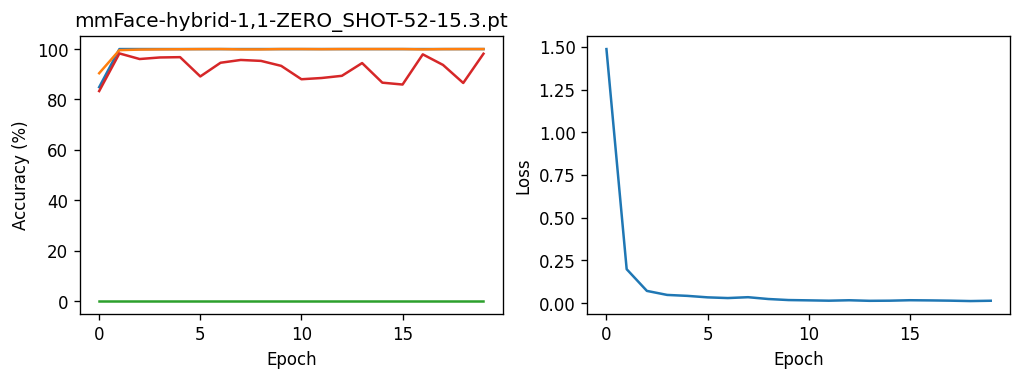

In [6]:
import matplotlib.pyplot as plt

losses, train_acc, val_acc = load_history(f"models/{model_name}")

fig, axs = plt.subplots(1, 2, figsize=(10, 3), dpi=120)

axs[0].plot(range(len(train_acc)), train_acc)
axs[0].plot(range(len(val_acc)), val_acc)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy (%)")

axs[1].plot(range(len(losses)), losses)
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")

axs[0].set_title(model_name)
plt.show()

### Subject Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import sys
sys.path.insert(1, "../../Soli/soli_realsense/")
from names import anon_names

subject_names = np.array(anon_names)

# Build confusion matrix
cf_matrix = confusion_matrix(preds_subject, true_subject)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=subject_names, columns=subject_names)
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')

C:\Users\jovin\AppData\Local\Temp\ipykernel_18044\1227521707.py:12: RuntimeWarning: invalid value encountered in divide
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=subject_names, columns=subject_names)


ValueError: Shape of passed values is (14, 14), indices imply (21, 21)

### Liveness Confusion Matrix

[Text(0.5, 25.722222222222214, 'Predictions'),
 Text(145.72222222222223, 0.5, 'Actual'),
 Text(0.5, 1.0, 'Precision Confusion Matrix')]

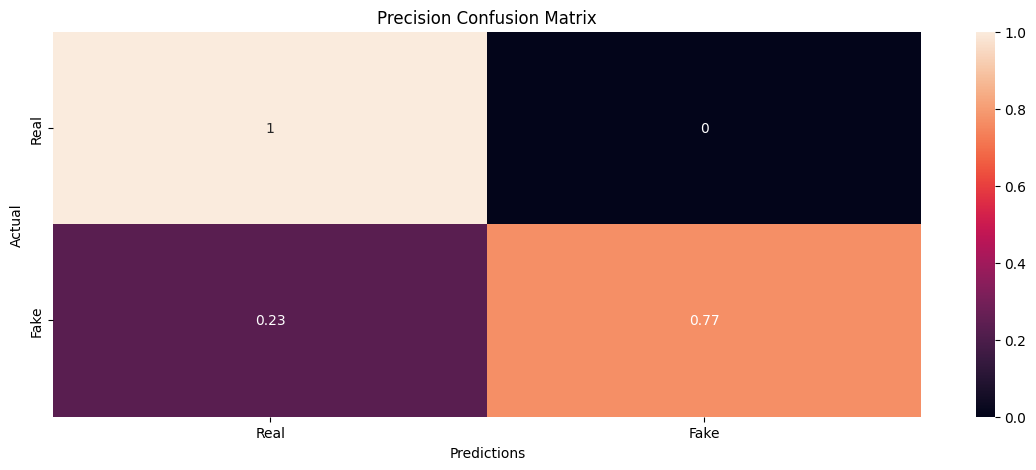

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import sys

# Build confusion matrix
cf_matrix = confusion_matrix(preds_liveness, true_liveness)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=["Real", "Fake"], columns=["Real", "Fake"])
plt.figure(figsize = (14, 5))
heatmap = sn.heatmap(df_cm, annot=True)
heatmap.set(xlabel ="Predictions", ylabel = "Actual", title ='Precision Confusion Matrix')